# hapDAF

In [1]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from ChromosomeWindows import window
import genominterv

np.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns

#sns.set()
# sns.set_style("whitegrid")

# style = {'axes.facecolor': 'black',
#  'axes.edgecolor': '.99',
#  'axes.labelcolor': '.99',
#  'figure.facecolor': 'black',
#  'grid.color': '.99',
#  'text.color': '.99',
#  'xtick.color': '.99',
#  'ytick.color': '.99',
#  'patch.edgecolor': 'w',
# }
# sns.set_style("darkgrid", rc=style)
#plt.style.use(style)

sns.set_palette('colorblind')
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])




Ignore deprecation warnings from mainly seaborn:

In [3]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Import variables global to the entire analysis:

In [4]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [5]:
scripts_dir = ag.root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

## Load meta data

In [6]:
# easy loading of meta data in a consistent manner across code
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pd.read_hdf(str(ag.results_dir / 'population_categories.store'), 'sr')
region_categories = pd.read_hdf(str(ag.results_dir / 'region_categories.store'), 'sr')
# region_colors = dict(zip(list(region_categories), 
#                          ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', 
#                           '#ff7f00', '#ffff33', '#a65628']))

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

In [7]:
# hapdaf_gen_chr7 = pd.read_table('/home/kmt/simons/faststorage/people/kmt/steps/1000genomes/hapdaf/hapdaf_7.txt', 
#                   sep=' ', skiprows=1, names=['phys_pos', 'gen_pos', 'hapdaf', 'deriv_freq'])
# hapdaf_gen_chrX = pd.read_table('/home/kmt/simons/faststorage/people/kmt/steps/1000genomes/hapdaf/hapdaf_X.txt', 
#                   sep=' ', skiprows=1, names=['phys_pos', 'gen_pos', 'hapdaf', 'deriv_freq'])
# hapdaf_gen_chrX.head()

In [8]:
hapdaf_phys_chr2 = pd.read_table('/home/kmt/simons/faststorage/people/kmt/steps/1000genomes/hapdaf/hapdaf_physical_2.txt', 
                  sep=' ', skiprows=1, names=['phys_pos', 'gen_pos', 'hapdaf', 'deriv_freq'])
hapdaf_phys_chr3 = pd.read_table('/home/kmt/simons/faststorage/people/kmt/steps/1000genomes/hapdaf/hapdaf_physical_3.txt', 
                  sep=' ', skiprows=1, names=['phys_pos', 'gen_pos', 'hapdaf', 'deriv_freq'])
hapdaf_phys_chr7 = pd.read_table('/home/kmt/simons/faststorage/people/kmt/steps/1000genomes/hapdaf/hapdaf_physical_7.txt', 
                  sep=' ', skiprows=1, names=['phys_pos', 'gen_pos', 'hapdaf', 'deriv_freq'])
hapdaf_phys_chr9 = pd.read_table('/home/kmt/simons/faststorage/people/kmt/steps/1000genomes/hapdaf/hapdaf_physical_9.txt', 
                  sep=' ', skiprows=1, names=['phys_pos', 'gen_pos', 'hapdaf', 'deriv_freq'])
hapdaf_phys_chrX = pd.read_table('/home/kmt/simons/faststorage/people/kmt/steps/1000genomes/hapdaf/hapdaf_physical_X.txt', 
                  sep=' ', skiprows=1, names=['phys_pos', 'gen_pos', 'hapdaf', 'deriv_freq'])
hapdaf_phys_chrX.head()

,phys_pos,gen_pos,hapdaf,deriv_freq
0,229542,229542,0.535010,0.518837
1,229645,229645,0.598474,0.505920
2,229651,229651,0.667275,0.472013
3,229771,229771,0.174531,0.430571
4,230206,230206,0.599305,0.471475


## Missing data

## hapDAF vs derived freq

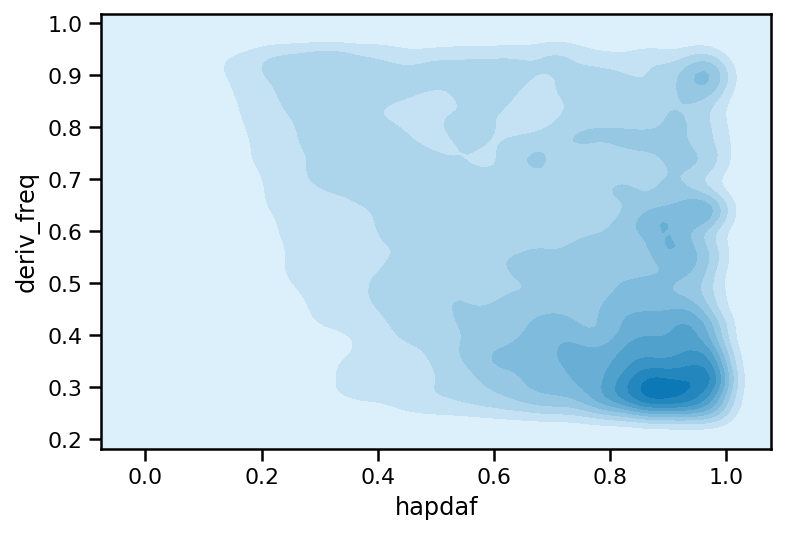

In [9]:
sns.kdeplot(hapdaf_phys_chrX.hapdaf, hapdaf_phys_chrX.deriv_freq, shade=True) ;

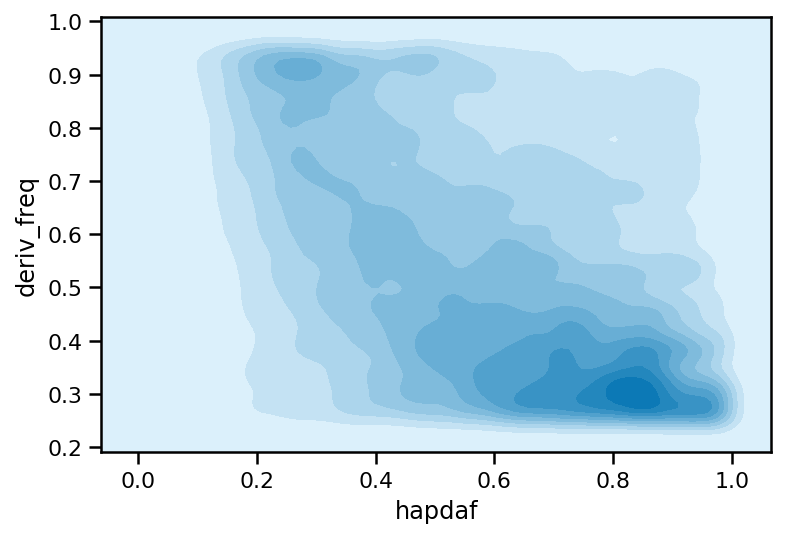

In [10]:
sns.kdeplot(hapdaf_phys_chr7.hapdaf, hapdaf_phys_chr7.deriv_freq, shade=True) ;

In [11]:
# @window(size=100000)
# def mean_hapdaf(df, fill='hg19'):
#     df.hapdaf.mean()

# hapdaf_phys_chrX.assign(start=hapdaf_phys_chrX.phys_pos, end=hapdaf_phys_chrX.phys_pos).pipe(mean_hapdaf)

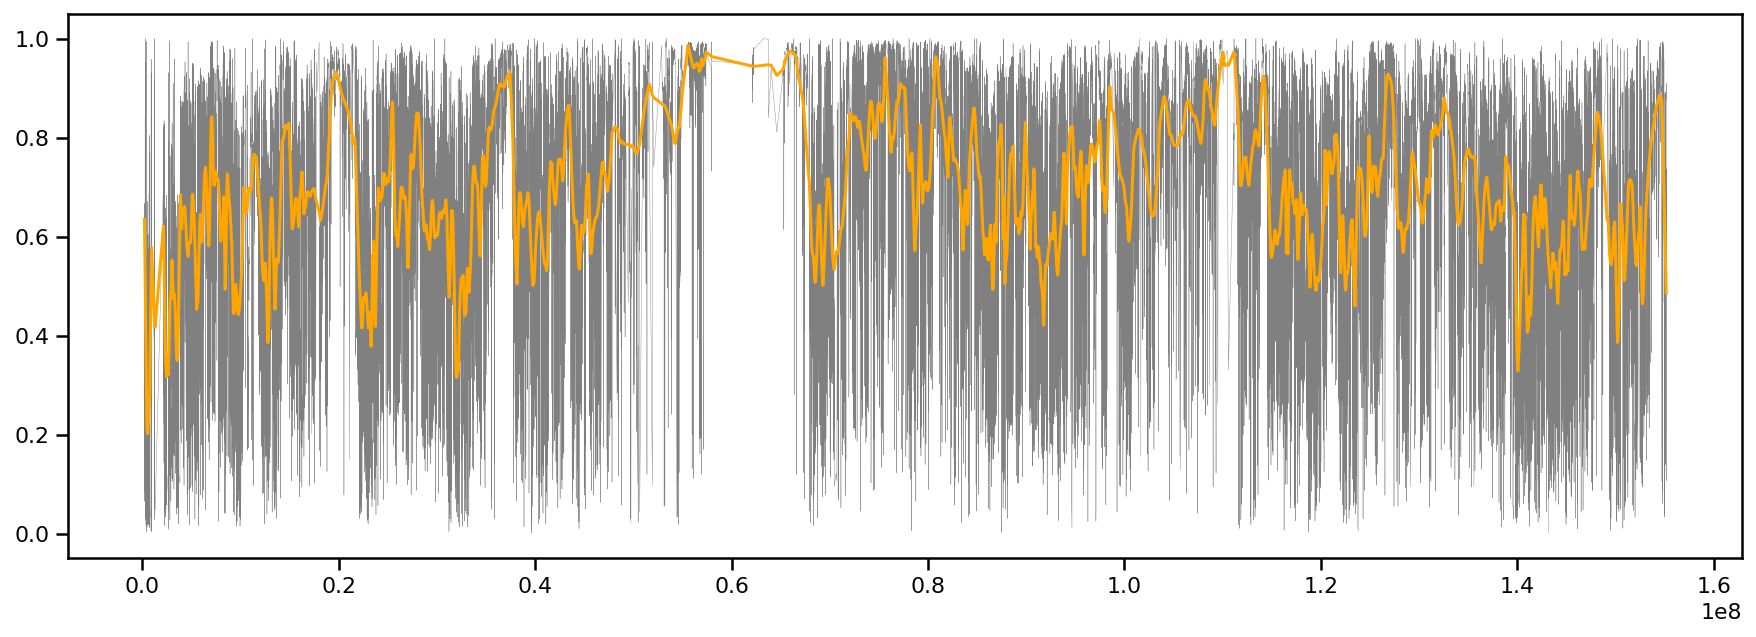

In [12]:
fig = plt.figure(figsize=(15, 5))

plt.plot(hapdaf_phys_chrX.phys_pos, hapdaf_phys_chrX.hapdaf, c='grey', linewidth=0.2)
filtered = lowess(hapdaf_phys_chrX.hapdaf, hapdaf_phys_chrX.phys_pos, 
                  is_sorted=True, frac=0.005, it=0)
plt.plot(filtered[:,0], filtered[:,1], color='orange') ;

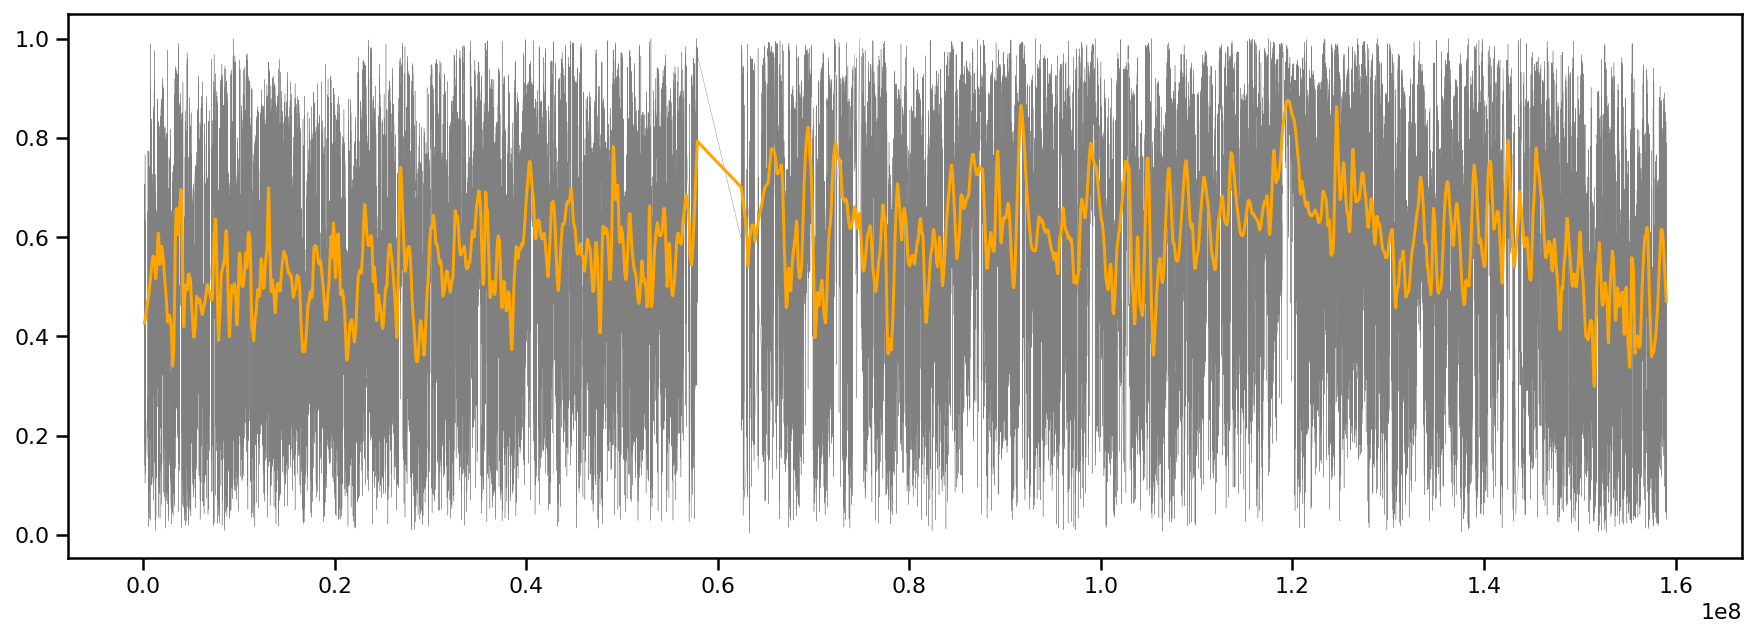

In [13]:
fig = plt.figure(figsize=(15, 5))

plt.plot(hapdaf_phys_chr7.phys_pos, hapdaf_phys_chr7.hapdaf, c='grey', linewidth=0.2)
filtered = lowess(hapdaf_phys_chr7.hapdaf, hapdaf_phys_chr7.phys_pos, 
                  is_sorted=True, frac=0.005, it=0)
plt.plot(filtered[:,0], filtered[:,1], color='orange') ;

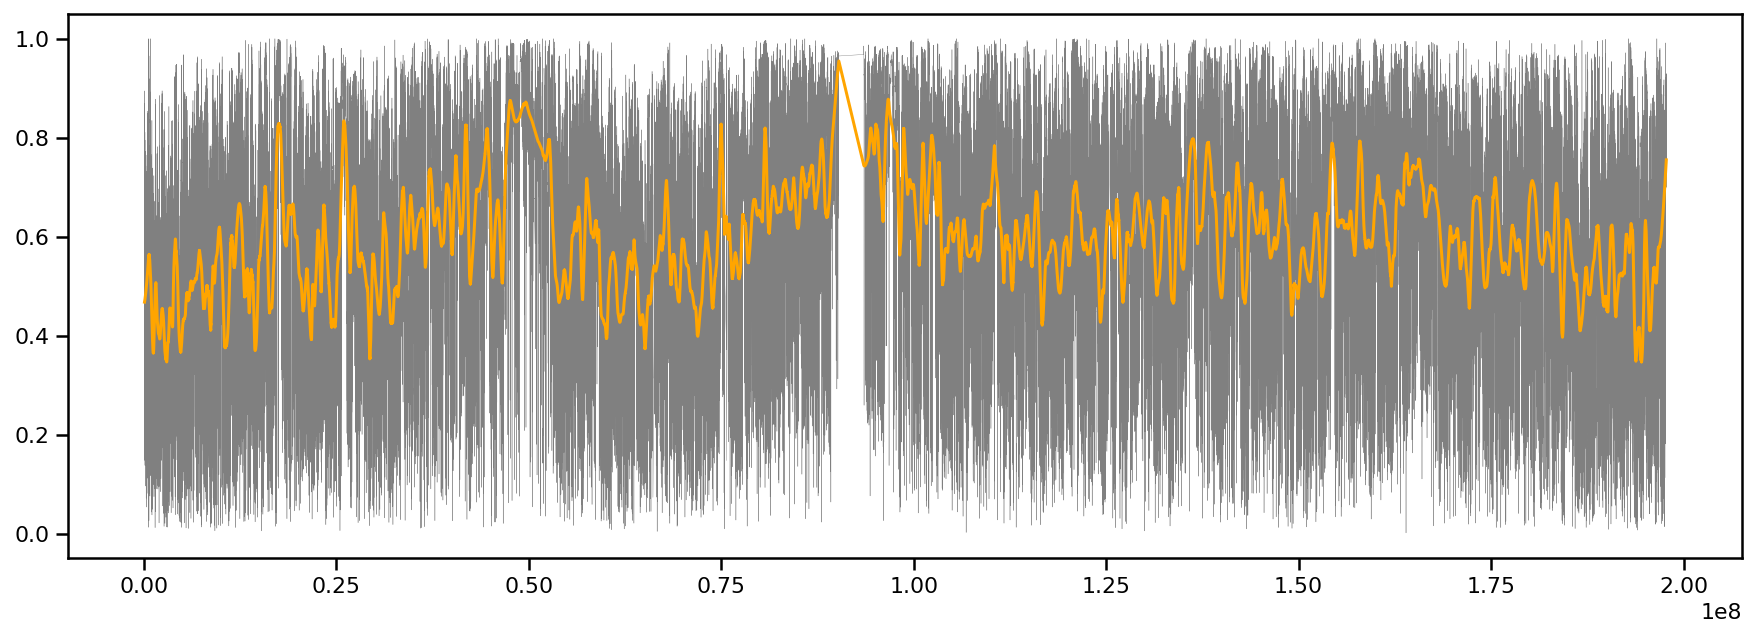

In [14]:
fig = plt.figure(figsize=(15, 5))

plt.plot(hapdaf_phys_chr3.phys_pos, hapdaf_phys_chr3.hapdaf, c='grey', linewidth=0.2)
filtered = lowess(hapdaf_phys_chr3.hapdaf, hapdaf_phys_chr3.phys_pos, 
                  is_sorted=True, frac=0.005, it=0)
plt.plot(filtered[:,0], filtered[:,1], color='orange') ;

In [15]:
# fig = plt.figure(figsize=(15, 5))
# plt.plot(hapdaf_phys_chrX.phys_pos, hapdaf_phys_chrX.hapdaf)
# mpld3.display(fig)

In [16]:
# fig = plt.figure(figsize=(15, 5))
# plt.plot(hapdaf_phys_chr7.phys_pos, hapdaf_phys_chr7.hapdaf)
# mpld3.display(fig)

In [17]:
extended_peak_regions_10 = pd.read_hdf(ag.results_dir / 'extended_peak_regions_10%.hdf')
extended_peak_regions_75 = pd.read_hdf(ag.results_dir / 'extended_peak_regions_75%.hdf')
extended_peak_regions_90 = pd.read_hdf(ag.results_dir / 'extended_peak_regions_90%.hdf')
human_chimp_low_ils_regions_chrX = pd.read_hdf(ag.results_dir / 'human_chimp_low_ils_regions_chrX.hdf')

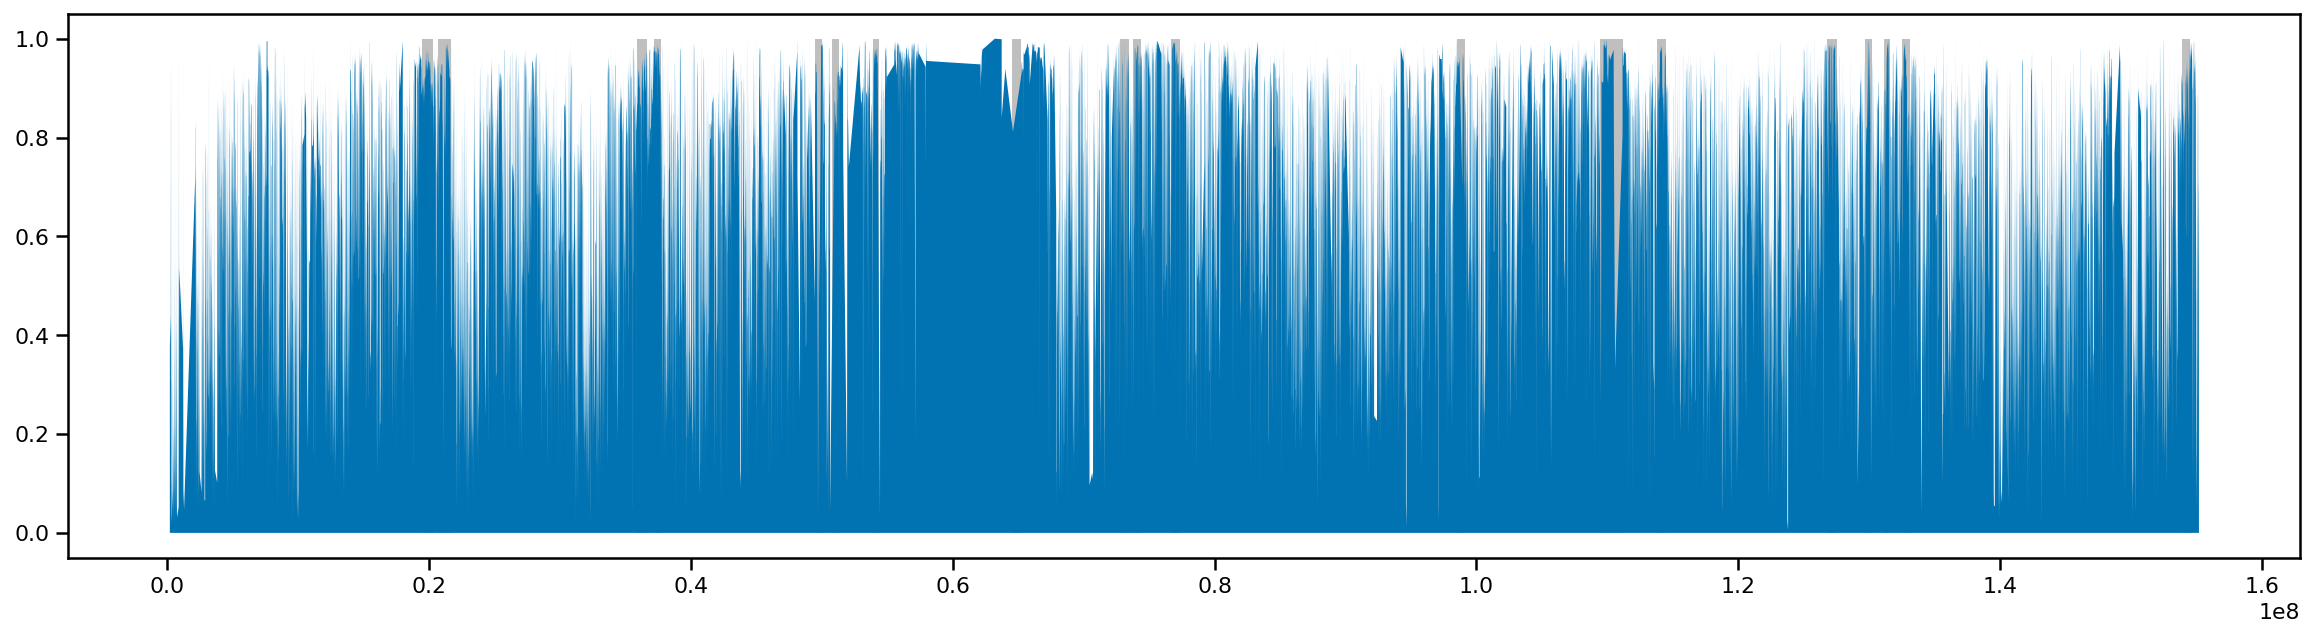

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
for tup in extended_peak_regions_75.itertuples():
    g = ax.add_patch(Rectangle((tup.start_pos, 0), tup.end_pos-tup.start_pos, 1, 
                 facecolor='gray',
                 linewidth=0,
                 alpha=0.5,
                 zorder=0))
plt.fill_between(hapdaf_phys_chrX.phys_pos, hapdaf_phys_chrX.hapdaf) ;

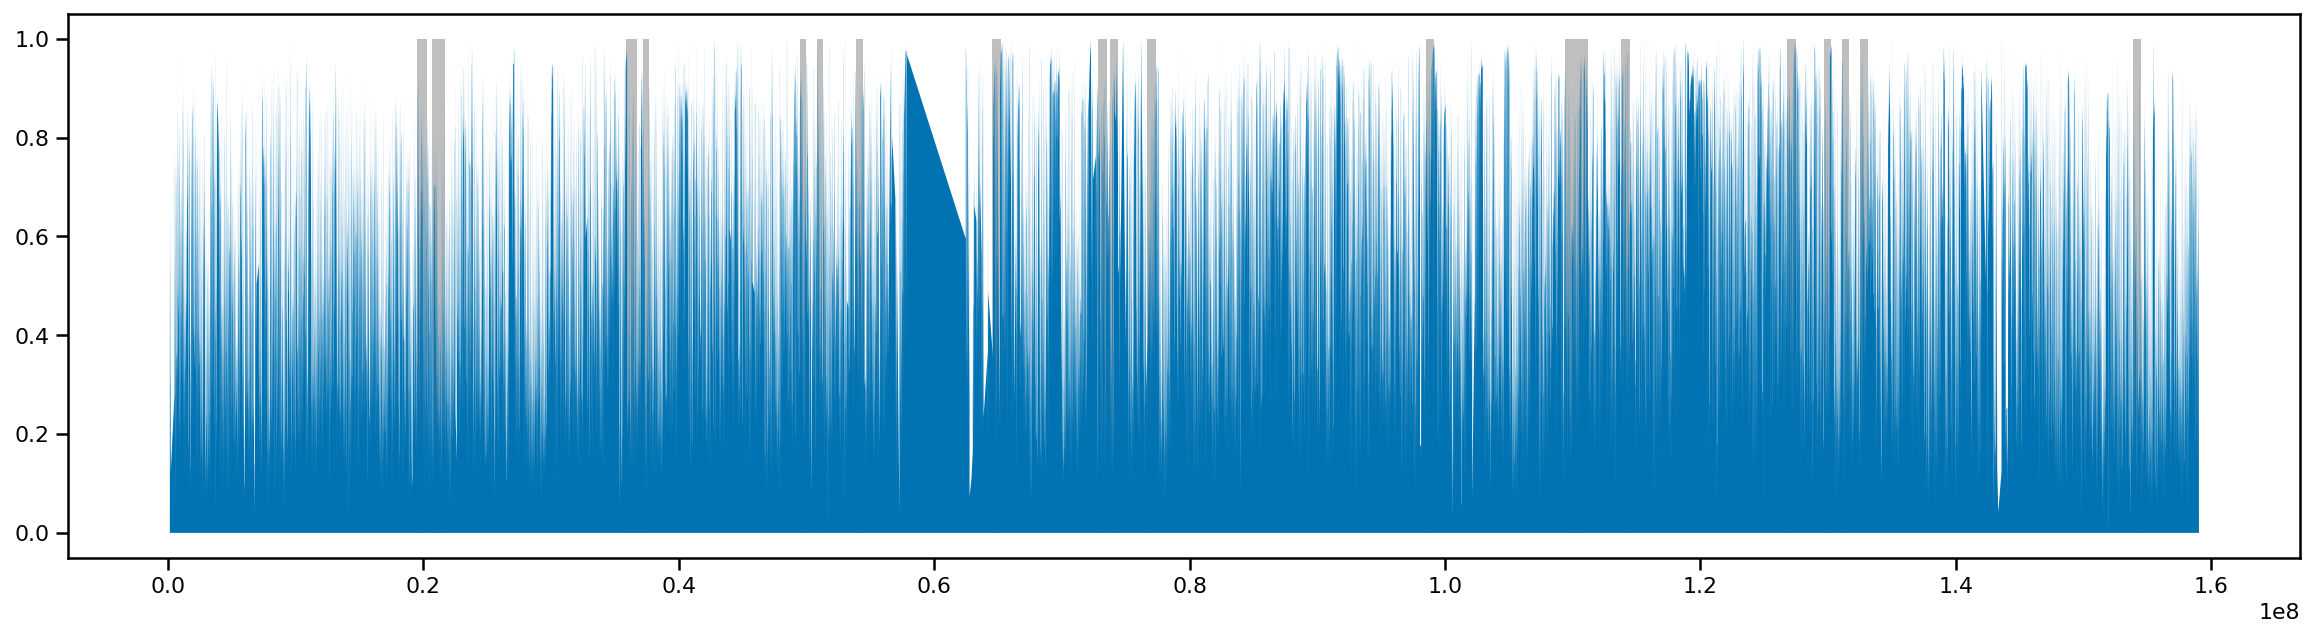

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
for tup in extended_peak_regions_75.itertuples():
    g = ax.add_patch(Rectangle((tup.start_pos, 0), tup.end_pos-tup.start_pos, 1, 
                 facecolor='gray',
                 linewidth=0,
                 alpha=0.5,
                 zorder=0))
plt.fill_between(hapdaf_phys_chr7.phys_pos, hapdaf_phys_chr7.hapdaf) ;

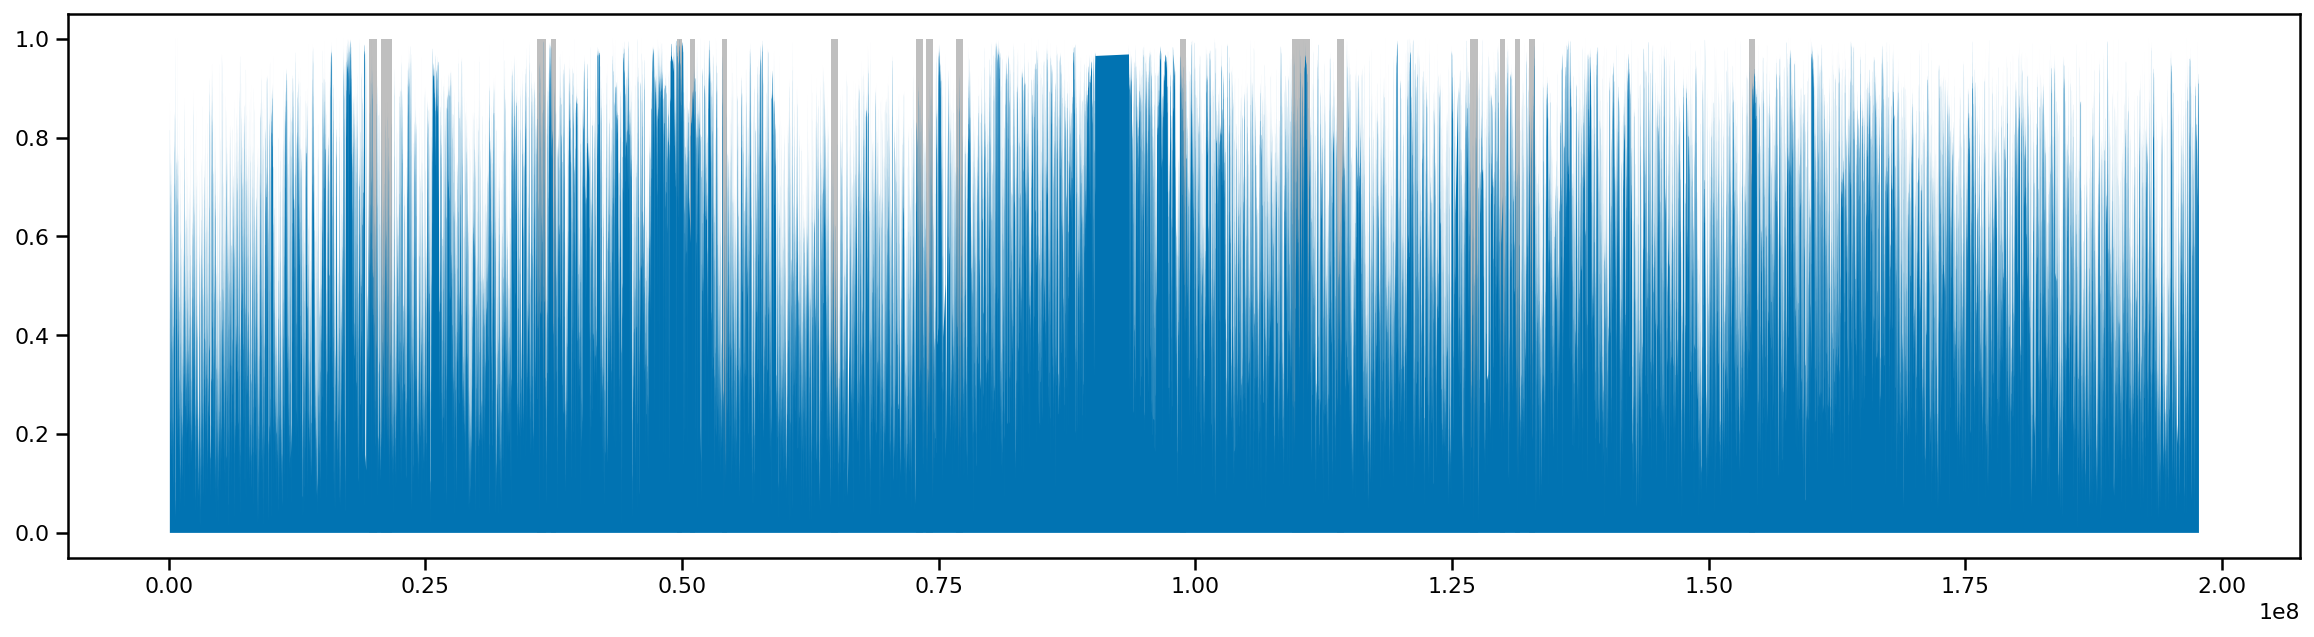

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
for tup in extended_peak_regions_75.itertuples():
    g = ax.add_patch(Rectangle((tup.start_pos, 0), tup.end_pos-tup.start_pos, 1, 
                 facecolor='gray',
                 linewidth=0,
                 alpha=0.5,
                 zorder=0))
plt.fill_between(hapdaf_phys_chr3.phys_pos, hapdaf_phys_chr3.hapdaf) ;

In [21]:
@window(size=200000)
def mean_hapdaf(df, fill='hg19'):
    if len(df):
        return df.hapdaf.mean()
    else:
        return np.nan

@window(size=500000)
def min_hapdaf(df, fill='hg19'):
    if len(df):
        return df.hapdaf.min()
    else:
        return np.nan

hapdaf_phys_chrX_10kb = (hapdaf_phys_chrX
                         .loc[lambda df: df.hapdaf > 0.25]
                         .assign(start=hapdaf_phys_chrX.phys_pos, 
                                 end=hapdaf_phys_chrX.phys_pos)
                         .pipe(min_hapdaf)
                        )

In [22]:
hapdaf_phys_chrX_10kb['rolling_min_hapdaf'] = hapdaf_phys_chrX_10kb.min_hapdaf.rolling(2).max()

In [23]:
def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

In [24]:
plot_df = stairs(hapdaf_phys_chrX_10kb) 

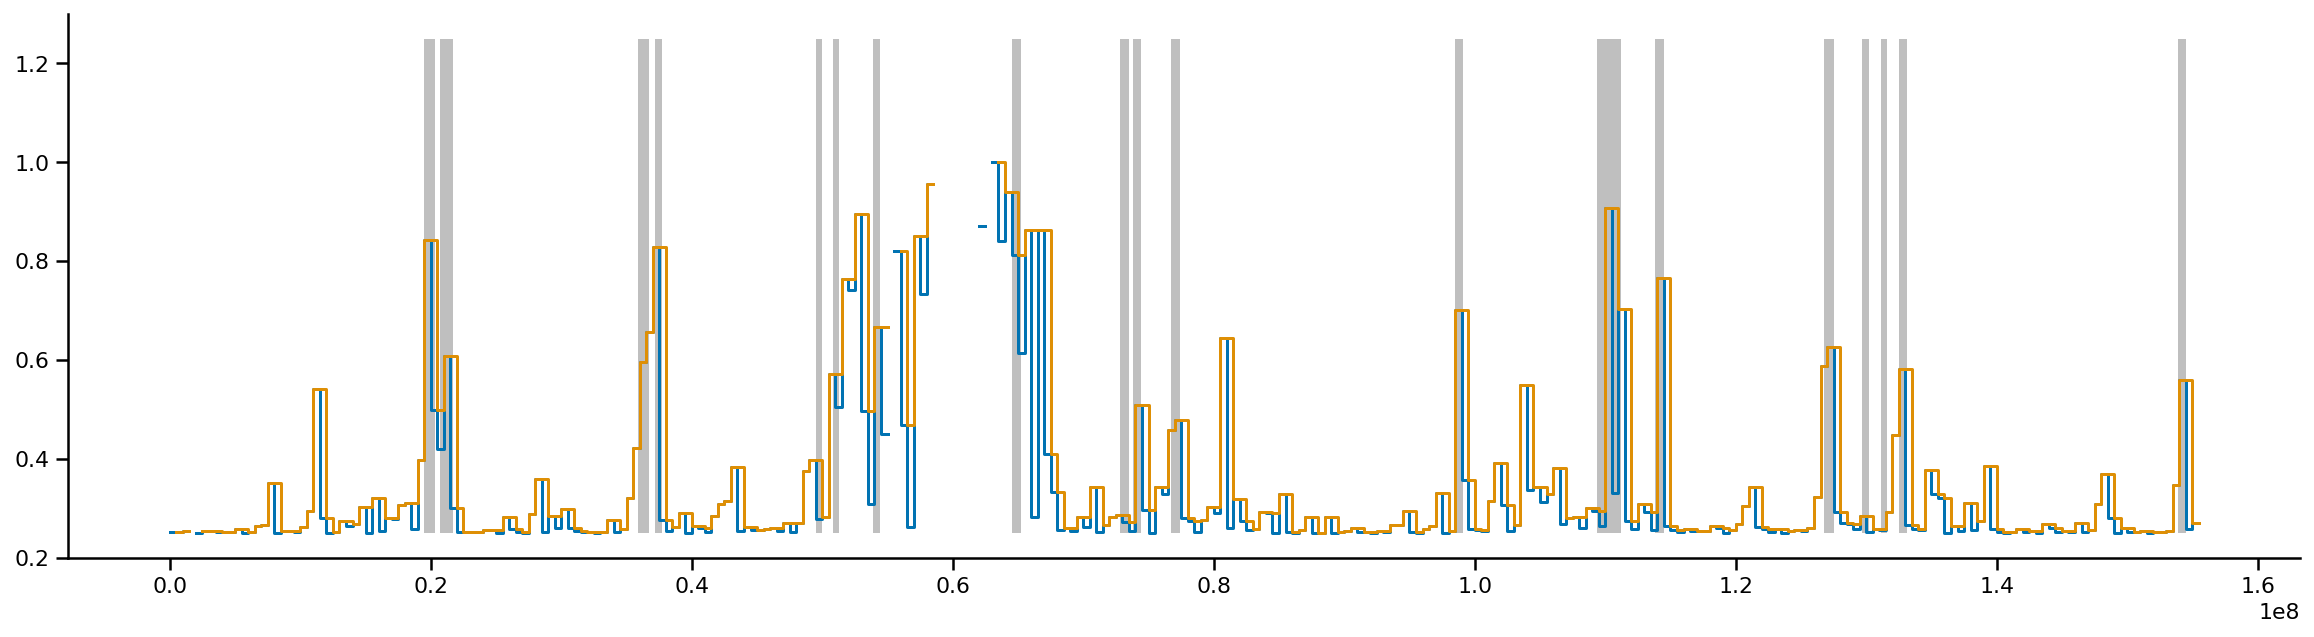

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
for tup in extended_peak_regions_75.itertuples():
    g = ax.add_patch(Rectangle((tup.start_pos, 0.25), tup.end_pos-tup.start_pos, 1, 
                 facecolor='gray',
                 linewidth=0,
                 alpha=0.5,
                 zorder=0))

plt.plot(plot_df.pos, plot_df.min_hapdaf) ;
plt.plot(plot_df.pos, plot_df.rolling_min_hapdaf) ;

sns.despine()

In [26]:
def min_hapdaf(df):
    res = df.loc[:, ['start', 'off', 'roll_win']].drop_duplicates().sort_values('start')
    res['min_hapdaf'] = df.hapdaf.min()
    return res
    
window_size = 100000
offsets = [0, 100000, 200000, 300000, 400000]
nr_wins = len(offsets)
lst = list()
# loop over five offsets of 500kb windows
for off in offsets:
    groups = (hapdaf_phys_chrX
                .assign(off=off, # keep offset
                        start = hapdaf_phys_chrX.phys_pos // window_size * window_size,
                        roll_win = lambda df: (off + df.phys_pos) // (5* window_size) * (5*window_size)) # label for rolling 500kb window
                .groupby(['roll_win', 'off'], as_index=False)
#                .filter(lambda df: df.roll_win.unique().size == nr_wins)             
#                .groupby(['roll_win', 'off'], as_index=False)
                )
    lst.append(groups.apply(min_hapdaf))

    # concatenate data frames for each offset and call windows as swept
df = pd.concat(lst)

scores = df.groupby('start').min_hapdaf.max().reset_index(name='score')
scores['end'] = scores.start + 100000

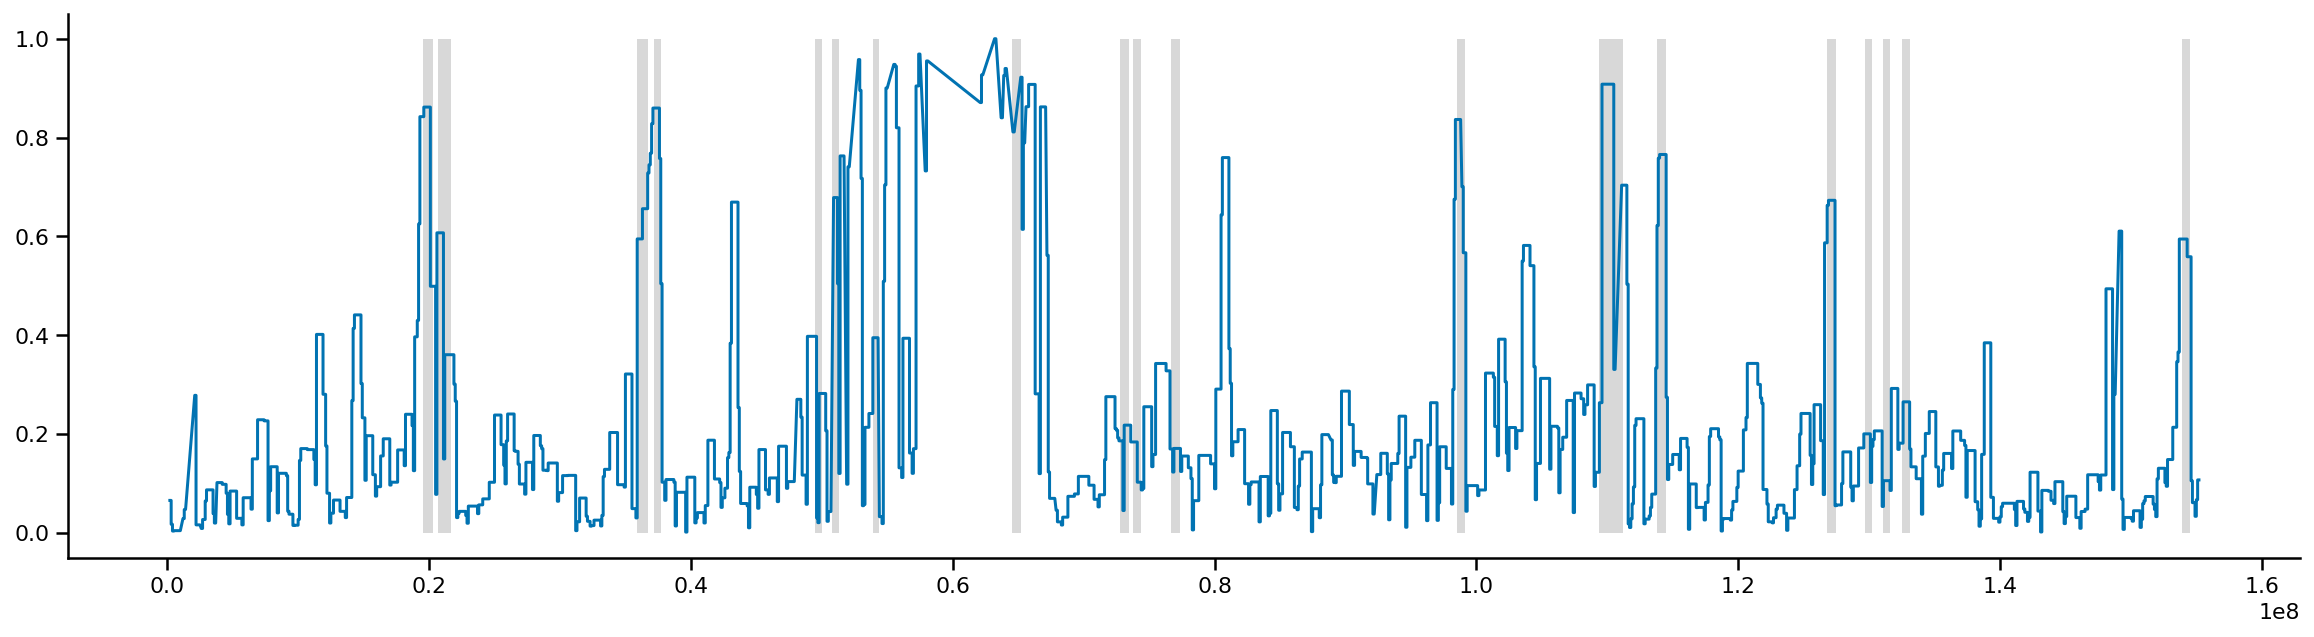

In [27]:
plot_df = stairs(scores)

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
for tup in extended_peak_regions_75.itertuples():
    g = ax.add_patch(Rectangle((tup.start_pos, 0), tup.end_pos-tup.start_pos, 1, 
                 facecolor='gray',
                 linewidth=0,
                 alpha=0.3,
                 zorder=0))

plt.plot(plot_df.pos, plot_df.score) ;

sns.despine()

# NB: Remove sites with too many missing values

In [28]:
def min_hapdaf(df):
    res = df.loc[:, ['start', 'off', 'roll_win']].drop_duplicates().sort_values('start')
    res['min_hapdaf'] = df.hapdaf.min()
    return res
    
window_size = 100000
offsets = [0, 100000, 200000, 300000, 400000]
nr_wins = len(offsets)
lst = list()
# loop over five offsets of 500kb windows
for off in offsets:
    groups = (hapdaf_phys_chr7
                .assign(off=off, # keep offset
                        start = hapdaf_phys_chr7.phys_pos // window_size * window_size,
                        roll_win = lambda df: (off + df.phys_pos) // (5* window_size) * (5*window_size)) # label for rolling 500kb window
                .groupby(['roll_win', 'off'], as_index=False)
#                .filter(lambda df: df.roll_win.unique().size == nr_wins)             
#                .groupby(['roll_win', 'off'], as_index=False)
                )
    lst.append(groups.apply(min_hapdaf))

    # concatenate data frames for each offset and call windows as swept
df = pd.concat(lst)

scores = df.groupby('start').min_hapdaf.max().reset_index(name='score')
scores['end'] = scores.start + 100000

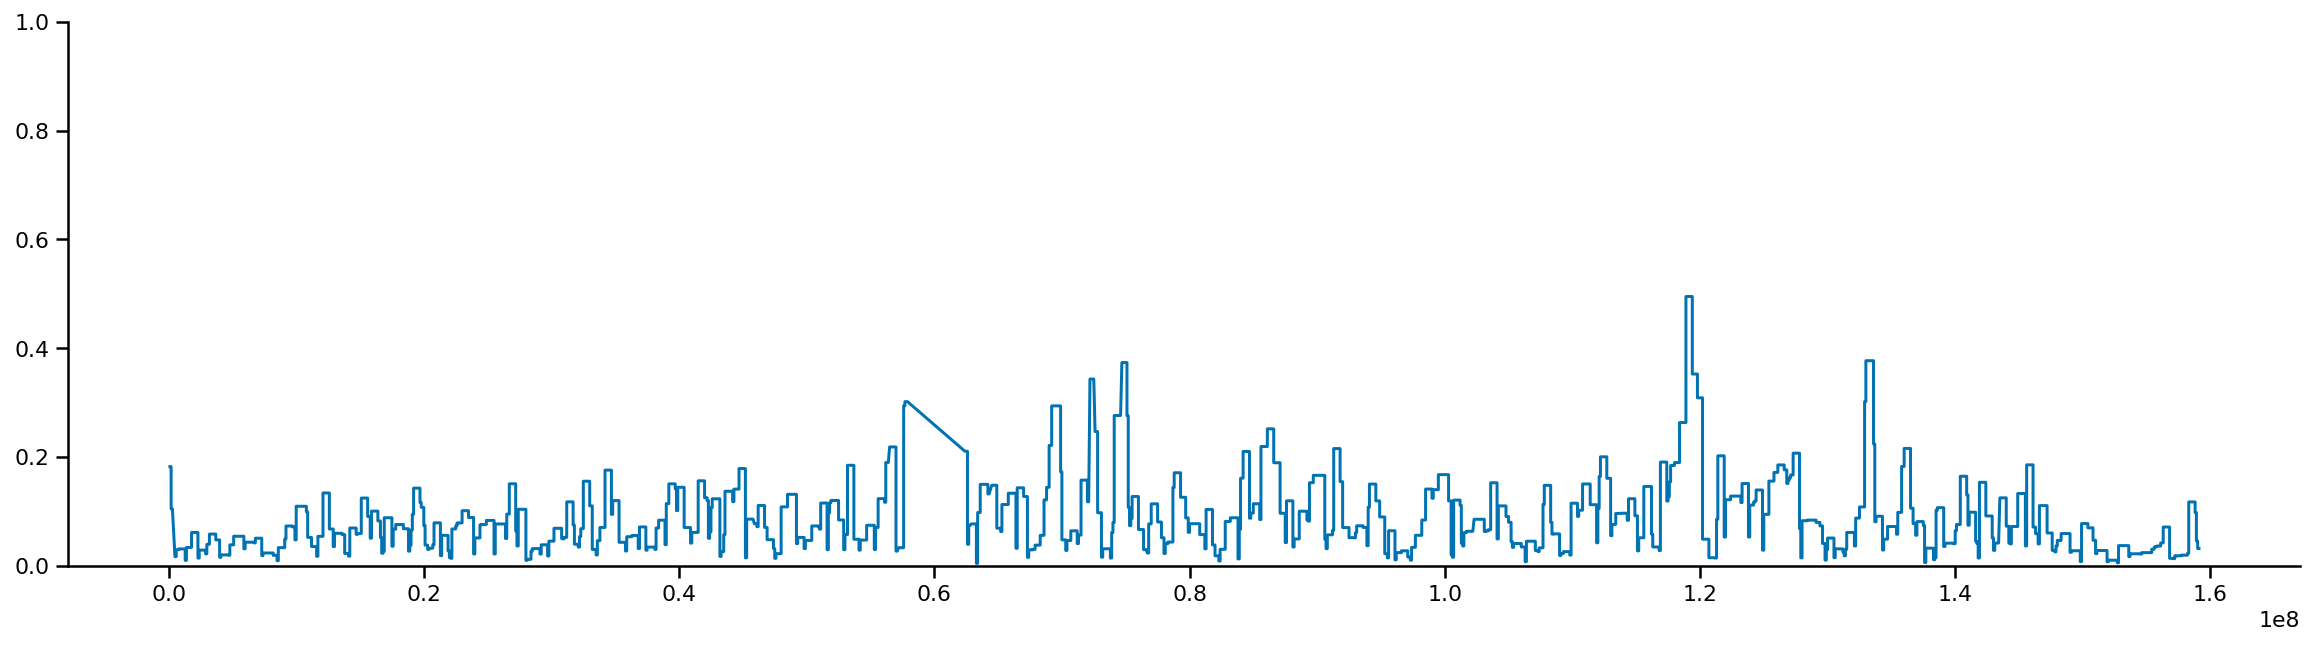

In [29]:
plot_df = stairs(scores)
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.plot(plot_df.pos, plot_df.score)
plt.ylim(0, 1)
sns.despine()

In [30]:
def min_hapdaf(df):
    res = df.loc[:, ['start', 'off', 'roll_win']].drop_duplicates().sort_values('start')
    res['min_hapdaf'] = df.hapdaf.min()
    return res
    
window_size = 100000
offsets = [0, 100000, 200000, 300000, 400000]
nr_wins = len(offsets)
lst = list()
# loop over five offsets of 500kb windows
for off in offsets:
    groups = (hapdaf_phys_chr2
                .assign(off=off, # keep offset
                        start = hapdaf_phys_chr2.phys_pos // window_size * window_size,
                        roll_win = lambda df: (off + df.phys_pos) // (5* window_size) * (5*window_size)) # label for rolling 500kb window
                .groupby(['roll_win', 'off'], as_index=False)
#                .filter(lambda df: df.roll_win.unique().size == nr_wins)             
#                .groupby(['roll_win', 'off'], as_index=False)
                )
    lst.append(groups.apply(min_hapdaf))

    # concatenate data frames for each offset and call windows as swept
df = pd.concat(lst)

scores = df.groupby('start').min_hapdaf.max().reset_index(name='score')
scores['end'] = scores.start + 100000

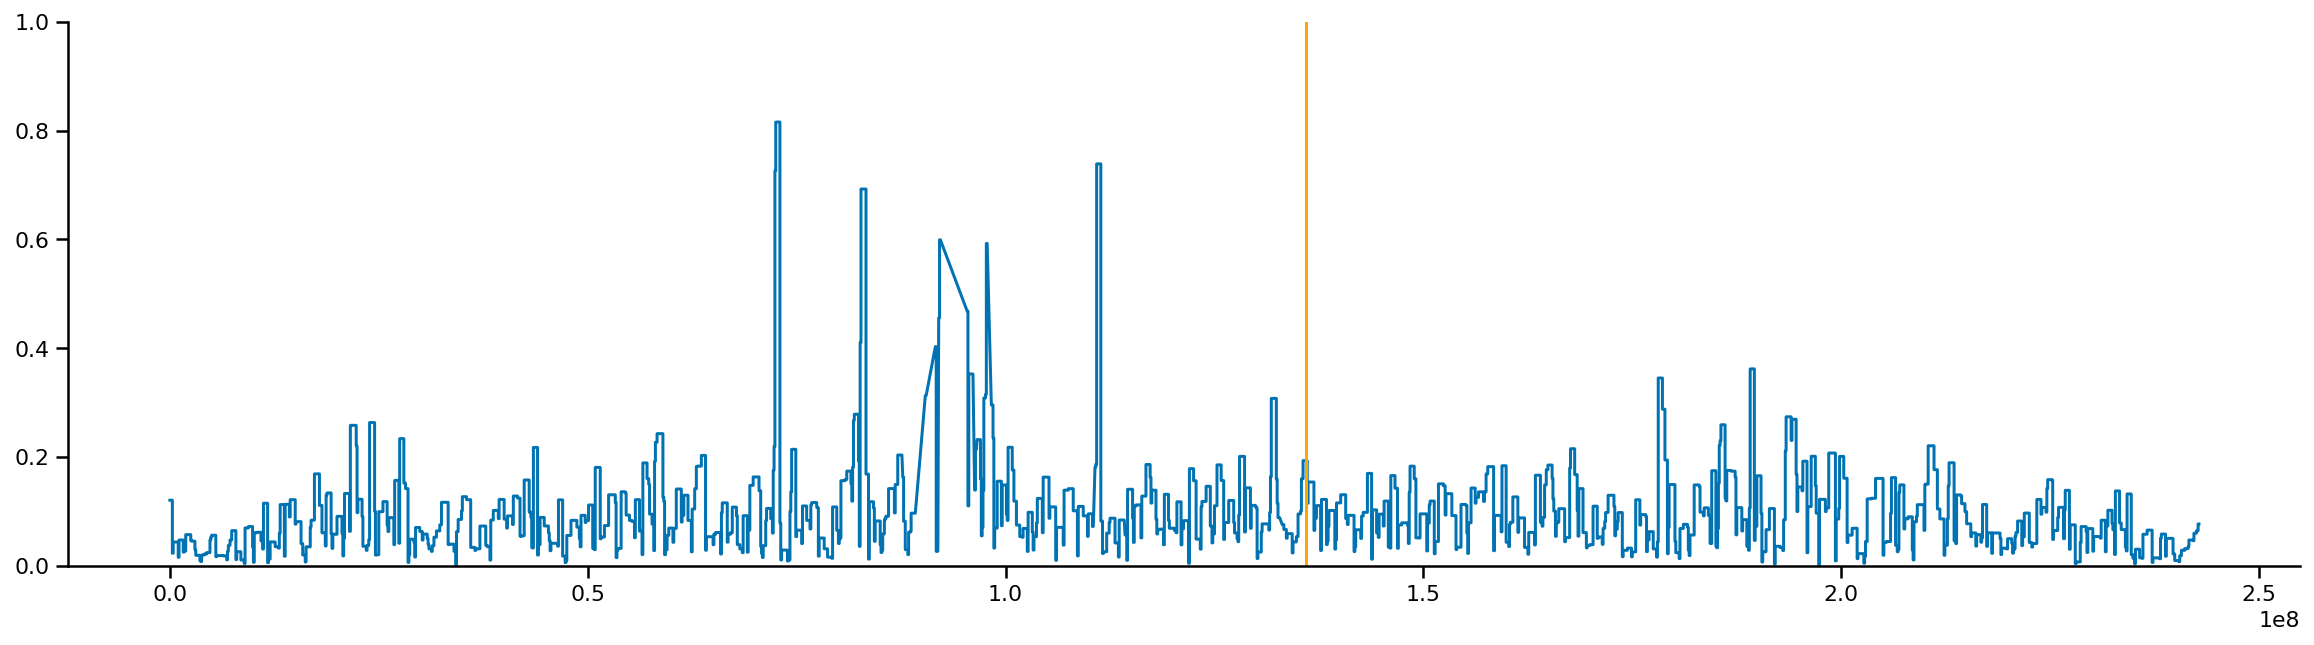

In [31]:
plot_df = stairs(scores)
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.plot(plot_df.pos, plot_df.score)
plt.ylim(0, 1)
plt.axvline(x=136000000, color='orange')
sns.despine()

In [32]:
def min_hapdaf(df):
    res = df.loc[:, ['start', 'off', 'roll_win']].drop_duplicates().sort_values('start')
    res['min_hapdaf'] = df.hapdaf.min()
    return res
    
window_size = 100000
offsets = [0, 100000, 200000, 300000, 400000]
nr_wins = len(offsets)
lst = list()
# loop over five offsets of 500kb windows
for off in offsets:
    groups = (hapdaf_phys_chr3
                .assign(off=off, # keep offset
                        start = hapdaf_phys_chr3.phys_pos // window_size * window_size,
                        roll_win = lambda df: (off + df.phys_pos) // (5* window_size) * (5*window_size)) # label for rolling 500kb window
                .groupby(['roll_win', 'off'], as_index=False)
#                .filter(lambda df: df.roll_win.unique().size == nr_wins)             
#                .groupby(['roll_win', 'off'], as_index=False)
                )
    lst.append(groups.apply(min_hapdaf))

    # concatenate data frames for each offset and call windows as swept
df = pd.concat(lst)

scores = df.groupby('start').min_hapdaf.max().reset_index(name='score')
scores['end'] = scores.start + 100000

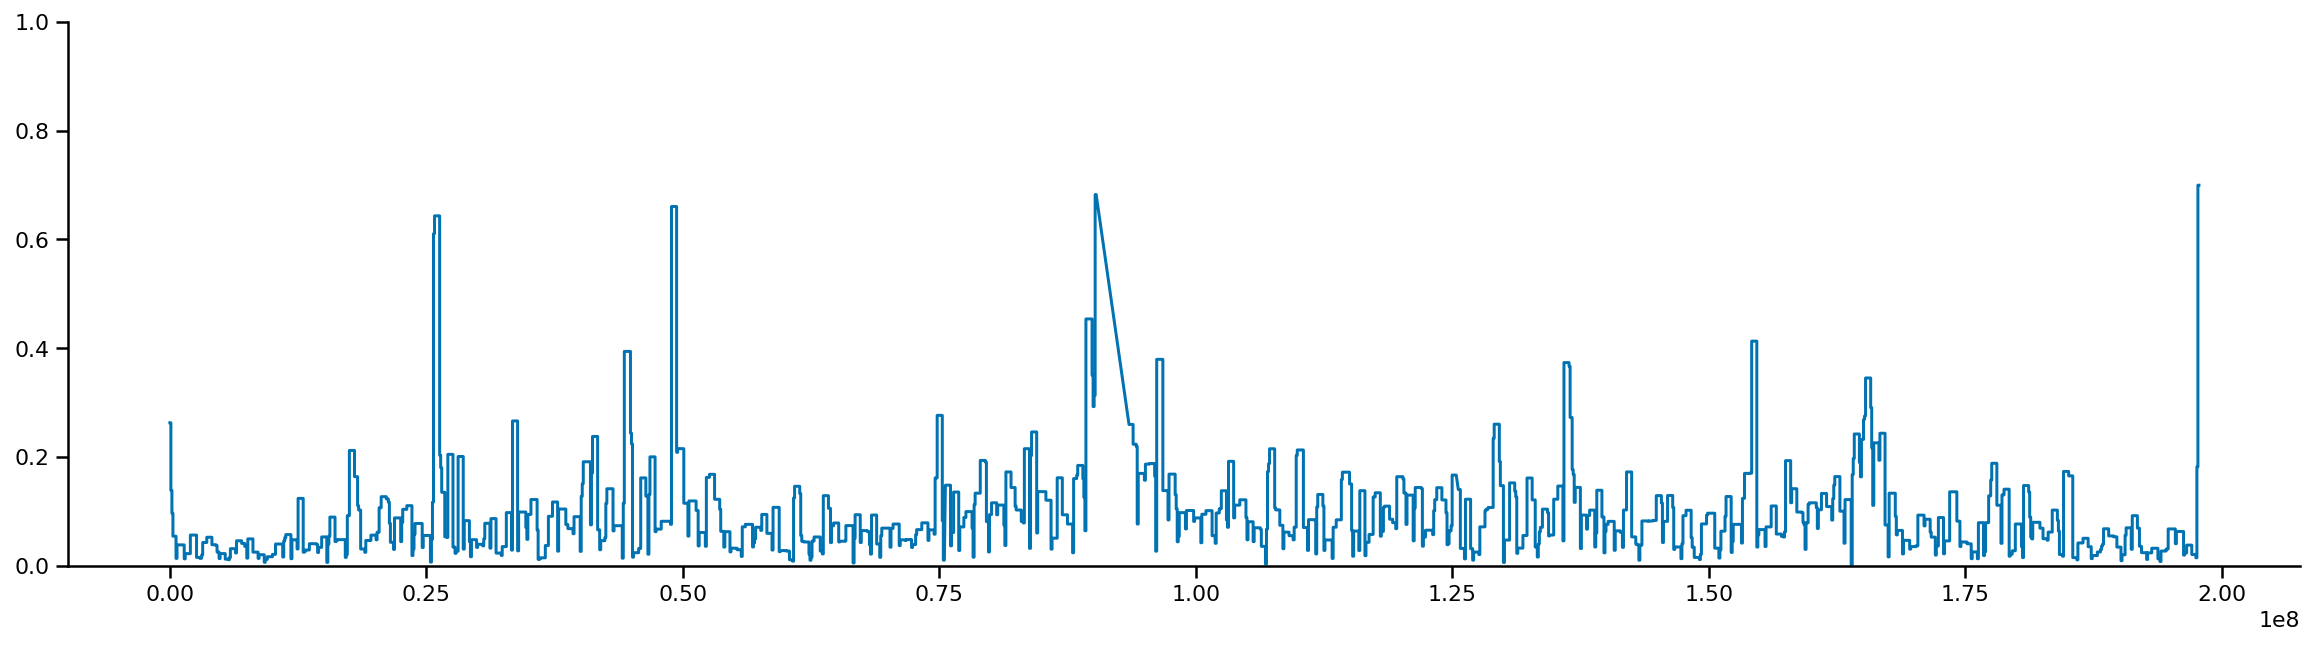

In [33]:
plot_df = stairs(scores)
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.plot(plot_df.pos, plot_df.score)
plt.ylim(0, 1)
sns.despine()

In [34]:
def min_hapdaf(df):
    res = df.loc[:, ['start', 'off', 'roll_win']].drop_duplicates().sort_values('start')
    res['min_hapdaf'] = df.hapdaf.min()
    return res
    
window_size = 100000
offsets = [0, 100000, 200000, 300000, 400000]
nr_wins = len(offsets)
lst = list()
# loop over five offsets of 500kb windows
for off in offsets:
    groups = (hapdaf_phys_chr9
                .assign(off=off, # keep offset
                        start = hapdaf_phys_chr9.phys_pos // window_size * window_size,
                        roll_win = lambda df: (off + df.phys_pos) // (5* window_size) * (5*window_size)) # label for rolling 500kb window
                .groupby(['roll_win', 'off'], as_index=False)
#                .filter(lambda df: df.roll_win.unique().size == nr_wins)             
#                .groupby(['roll_win', 'off'], as_index=False)
                )
    lst.append(groups.apply(min_hapdaf))

    # concatenate data frames for each offset and call windows as swept
df = pd.concat(lst)

scores = df.groupby('start').min_hapdaf.max().reset_index(name='score')
scores['end'] = scores.start + 100000

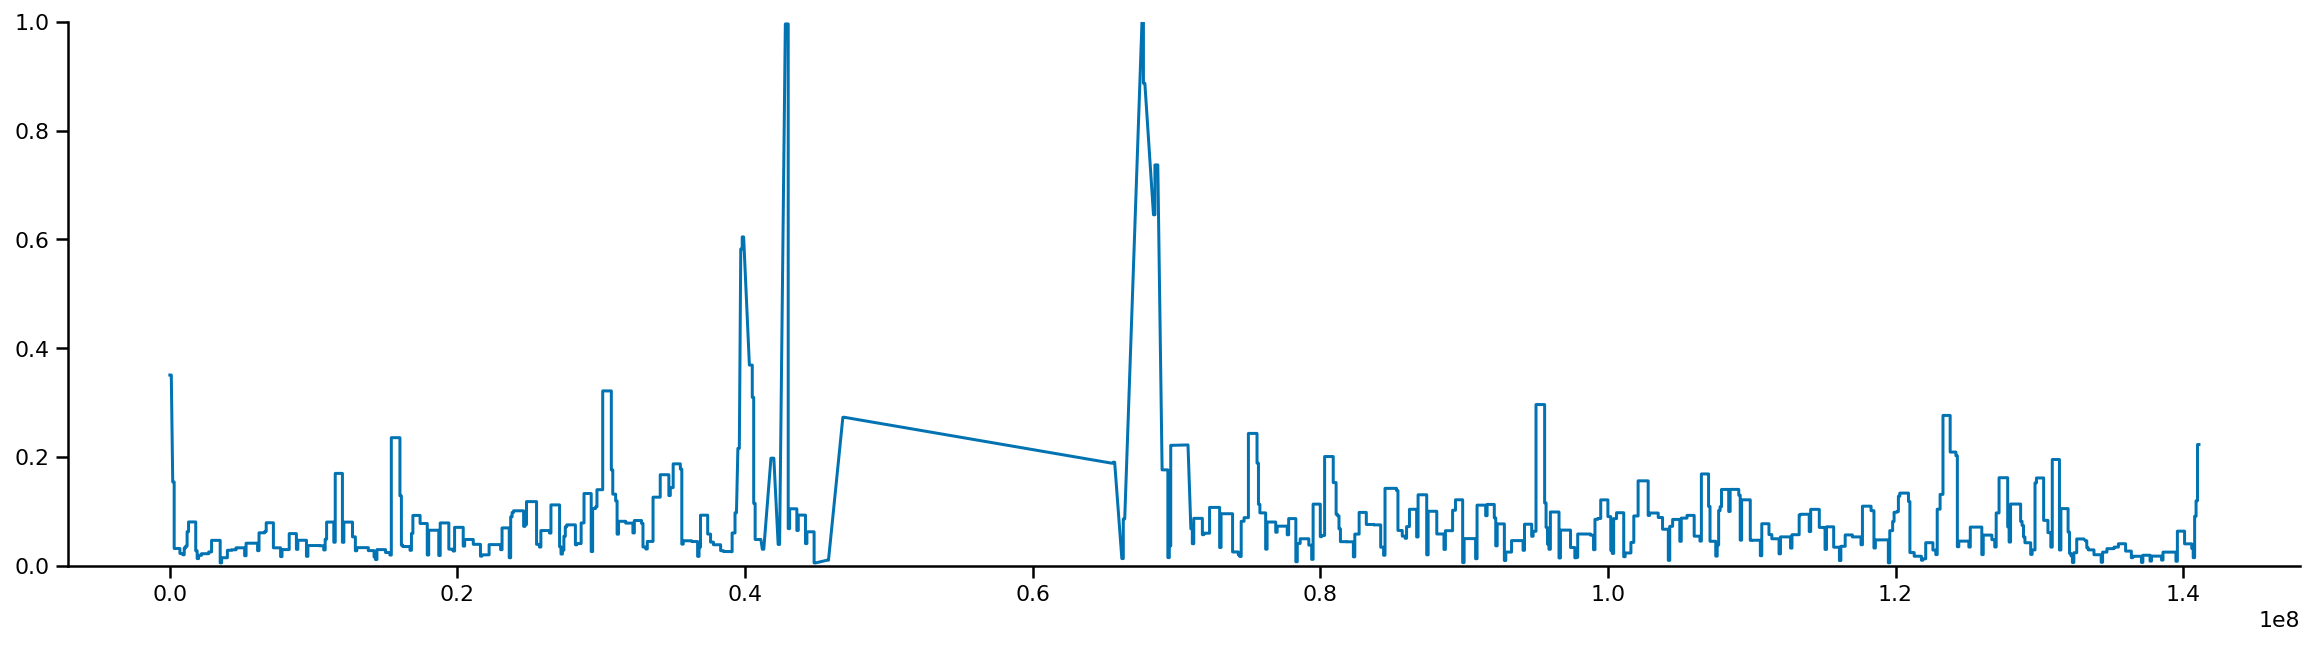

In [35]:
plot_df = stairs(scores)
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.plot(plot_df.pos, plot_df.score)
plt.ylim(0, 1)
sns.despine()